**Author Information**
* Barry Li: 
    * 260912069
    * weien.li@mail.mcgill.ca
* Minzhe Feng: 
    * 260886087
    * minzhe.feng@mail.mcgill.ca

[Colab Link for this Notebook](https://colab.research.google.com/drive/1lRNZ-mqN9oNLT-QwwleTMCVwTzVrGRnK?usp=sharing)

In [ ]:
# Colab doesn't come with gymnasium by default
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import random

# Question 1.

**Report**
* **Experiment Description**:  
We tested 1-step SARSA and Expected SARSA algorithms with Boltzmann softmax exploration on the standard $4\times4$Frozen Lake environment for this 
experiment. The parameters of attention in this experiment are temperature for
the softmax algorithm and learning rate for (Expected) SARSA. We pick 3 different values for each, yielding $3\times3=9$ different combinations of parameters.
* **Parameter Choice**:
    * **Discount Factor $\gamma$**: Not a main focus in this experiment. After trying out a handful of different values, we settled at a generic $0.95$ that appeared to perform reasonably well.  
    * **Temperature**: This controls the allocation of exploration vs. exploitation in the softmax algorithm. Too high a temperature (more exploration) causes the agent to fall into a hole more often, resulting in small returns, while too low a temperature (more exploitation) seems to induce large fluctuations in per-episode returns over time, which can be observed in the learning curve. We ultimately settled at 0.5, 1 & 2 for temperature.
    * **Learning Rate $\alpha$**: A large $\alpha$ means more aggressive adjustments, which can lead to fluctuating training results, while a small $\alpha$ generally has a slow convergence speed. After some trials, we settled at three smaller values of 0.0625, 0.125 & 0.25.  
    * From our experiments, the best parameter combinations are $TEMP = 0.5, \alpha = 0.125$ for SARSA and $TEMP = 1, \alpha = 0.125$ for Expected SARSA.
* **Conclusions**:  
From the plots below, it can be observed at least for this sample size, SARSA and Expected SARSA have very comparable performance in terms of discounted returns. However, we can see from the last learning curves plots, which depicts the testing performance over the whole 500 segments, alone that Expected SARSA fares marginally better than SARSA in terms of stability, with a more centered distribution of points across different segments.


In [ ]:
TEMP = (0.5, 1, 2)
# TEMP = (0.0625, 0.125, 0.25)
# Alpha is the learning rate
# ALPHA = (0.75, 0.85, 0.95)
ALPHA = (0.0625, 0.125, 0.25)
# Discount factor gamma is not the main topic of
# this question, so fix it at a generic 0.95 here
GAMMA = 0.95

def boltzmann(Q, state, temp, action_size=4):
    pref_vector = Q[state, :] / temp
    softmax = np.exp(pref_vector)
    return np.random.choice(action_size, p=softmax / softmax.sum())

# SARSA
def update(Q, state, state_next, action, action_next, reward, alpha):
    td = reward + GAMMA * Q[state_next, action_next] - Q[state, action]
    Q[state, action] = Q[state, action] + alpha * td

# Expected SARSA
def update_exp(Q, state, state_next, action, reward, alpha, temp):
    pref_vector = Q[state_next, :] / temp
    softmax = np.exp(pref_vector)
    pi = softmax / softmax.sum()
    expected = (pi * Q[state_next, :]).sum()
    td = reward + GAMMA * expected - Q[state, action]
    Q[state, action] = Q[state, action] + alpha * td

# 测试用！！！
epsilon= 0.9
def choose_action(state, env, Q):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :])
    return action

In [ ]:
def sarsa(expected: bool):
    training_final = []
    testing_final = []
    all_final = []
    for alpha in ALPHA:
        for temp in TEMP:
            training_returns = []
            testing_returns = []
            all_returns = []
            for run in range(10):
                env1 = gym.make("FrozenLake-v1")
                obs_size = env1.observation_space.n
                action_size = env1.action_space.n
                Q = np.zeros((obs_size, action_size))
                training_return = []
                all_return = []
                for episode in range(5500):
                    state = env1.reset()[0]
                    action = boltzmann(Q, state, temp)
                    training = 0
                    t = 0
                    while True:
                        state_next, reward, done, timeout, _= env1.step(action)
                        # if done and episode >= 5489 and episode <= 5498:
                        #     print(alpha, temp, t, episode, reward)
                        if (episode + 1) % 11 == 0:
                            action_next = np.argmax(Q[state_next, :])
                        else:
                            action_next = boltzmann(Q, state_next, temp)
                            # action_next = choose_action(state_next, env1, Q)
                        if not expected:
                            update(Q, state, state_next, action, 
                                action_next, reward, alpha)
                        else:
                            update_exp(Q, state, state_next, action, 
                                       reward, alpha, temp)
                        state = state_next
                        action = action_next
                        training += reward * GAMMA**t
                        if done or timeout:
                            break
                        t += 1
                    all_return.append(training)
                    if episode >= 5489 and episode <= 5498:
                        training_return.append(training)
                    if episode == 5499:
                        testing_returns.append(training)
                training_returns.append(training_return)
                all_returns.append(all_return)
            training_final.append(training_returns)
            testing_final.append(testing_returns)
            all_final.append(all_returns)
    return training_final, testing_final, all_final

In [ ]:
sarsa_training, sarsa_testing, sarsa_all = sarsa(expected=False)
sarsa_training = np.array(sarsa_training)
sarsa_testing = np.array(sarsa_testing)
sarsa_all = np.array(sarsa_all)
sarsa_training_avg = sarsa_training.sum(axis=(1, 2)) / 100
sarsa_testing_avg = sarsa_testing.sum(1) / 10

In [ ]:
exp_sarsa_training, exp_sarsa_testing, exp_sarsa_all = sarsa(expected=True)
exp_sarsa_training = np.array(exp_sarsa_training)
exp_sarsa_testing = np.array(exp_sarsa_testing)
exp_sarsa_all = np.array(exp_sarsa_all)
exp_sarsa_training_avg = exp_sarsa_training.sum(axis=(1, 2)) / 100
exp_sarsa_testing_avg = exp_sarsa_testing.sum(1) / 10

## Final Training Performance

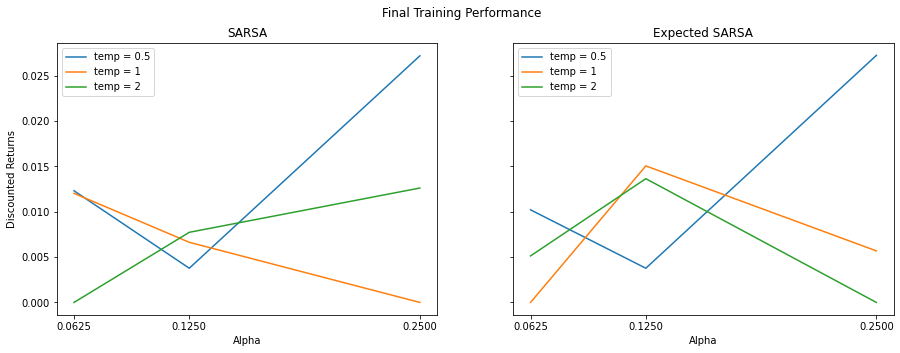

In [ ]:
figs, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
for (i, temp) in enumerate(TEMP):
    axes[0].plot(ALPHA, sarsa_training_avg[i::3], label=f"temp = {temp}")
    axes[1].plot(ALPHA, exp_sarsa_training_avg[i::3], label=f"temp = {temp}")
axes[0].set_xticks(ALPHA)
axes[0].set_xlabel("Alpha")
axes[0].set_ylabel("Discounted Returns")
axes[0].set_title("SARSA")
axes[1].set_xticks(ALPHA)
axes[1].set_xlabel("Alpha")
axes[1].set_title("Expected SARSA")
axes[0].legend()
axes[1].legend()
figs.suptitle("Final Training Performance")
plt.show()

## Final Testing Performance

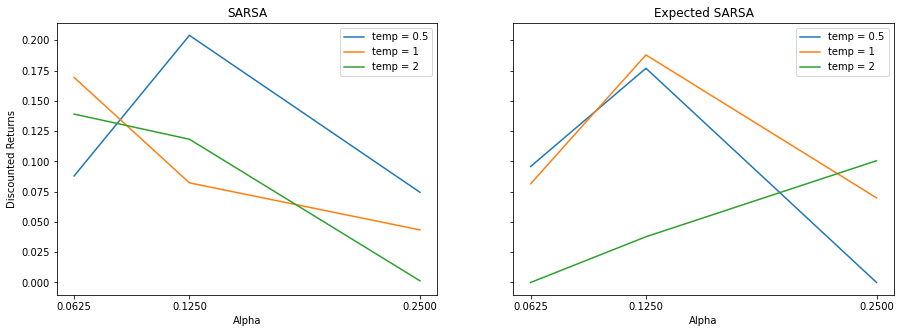

In [ ]:
figs, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
for (i, temp) in enumerate(TEMP):
    axes[0].plot(ALPHA, sarsa_testing_avg[i::3], label=f"temp = {temp}")
    axes[1].plot(ALPHA, exp_sarsa_testing_avg[i::3], label=f"temp = {temp}")
axes[0].set_xticks(ALPHA)
axes[0].set_xlabel("Alpha")
axes[0].set_ylabel("Discounted Returns")
axes[0].set_title("SARSA")
axes[1].set_xticks(ALPHA)
axes[1].set_xlabel("Alpha")
axes[1].set_title("Expected SARSA")
axes[0].legend()
axes[1].legend()
plt.show()

## Learning Curves

Here we picked $TEMP = 0.5, \alpha = 0.125$ for SARSA and $TEMP = 1, \alpha = 0.125$ for Expected SARSA. These two configurstions balance training and testing returns the best.

We also only plotted the testing episode performance for all 500 segments, as including training episodes makes the plots overly noisy, and testing performance is already a reliable indictor of each algorithm's performance.

In [ ]:
sarsa_means = sarsa_all.mean(axis=1) #average of each segment for all runs
sarsa_stds = sarsa_all.std(axis=1, ddof=1) / np.sqrt(10)
exp_sarsa_means = exp_sarsa_all.mean(axis=1)
exp_sarsa_stds = exp_sarsa_all.std(axis=1, ddof=1) / np.sqrt(10)

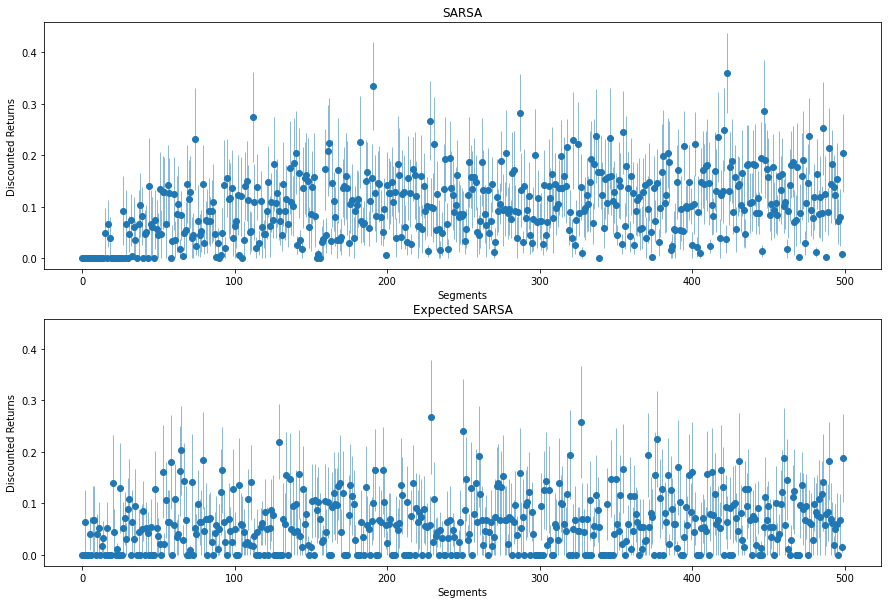

In [ ]:
x = np.arange(500)
figs, axes = plt.subplots(2, 1, sharey=True, figsize=(15, 10))
axes[0].errorbar(x, sarsa_means[3][10::11],yerr=sarsa_stds[3][10::11],
                 fmt='o', elinewidth=0.5)
axes[0].set_title("SARSA")
axes[1].errorbar(x, exp_sarsa_means[4][10::11],yerr=exp_sarsa_stds[4][10::11],
                 fmt='o', elinewidth=0.5)
axes[1].set_title("Expected SARSA")
axes[0].set_xlabel("Segments")
axes[0].set_ylabel("Discounted Returns")
axes[1].set_xlabel("Segments")
axes[1].set_ylabel("Discounted Returns")
plt.show()

# Question 2.

**Best Parameter Choice**
* Q-Learning: $\alpha = 0.25, \epsilon = 0.125$
* Actor-Critic: $\alpha = 0.25$

**Report**
* **Experiment Description**  
This experiment operates on the classic cart pole environment that has four observed variables corresponding to properties of the car & the pole. One notable feature of this environment, especially when compared to that in `Q1`, is that the observation space is continuous. We discritize each observed variable into 10 bins by using one-hot encoding. For variables that are unbounded, we set an artificial bound and allocates out-of-bound values to their corresponding smallest/largest bin. After this treatment, we then apply Q-Learning (with $\epsilon$-greedy) and Actor-Critic (with softmax) algorithms on the discretized environment.

* **Parameter Choice**
    * **Learning Rate $\alpha$**: 1/4, 1/8 and 1/16 as required
    * **$\epsilon$ for Q-Learning & $\epsilon$-greedy**: We chose to also settle with 1/4, 1/8 and 1/16.
    * **Temperature for Actor-Critic & softmax**: We chose 2.
    * From our experiments, the best parameter combinations are $\alpha = 0.25, \epsilon = 0.125$ for Q-learning and $\alpha = 0.25$ for actor-critic.
* **Conclusion**
    * **For actor-critic**: Under the given $TEMP = 2$, $\alpha = 0.25$ displays a clear edge in terms of performance, as can be seen in the first plot.
    * **For Q-learning**: $\alpha = 0.25$ (the blue lines in the second plot) outperforms the other two $\alpha$'s by a small margin under all three values of $\epsilon$. Then, when comparing across different $\epsilon$'s, $\epsilon = 0.125$ has a slight advantage. Therefore, we settle with $\alpha = 0.25, \epsilon = 0.125$ as the best parameter choice for q-learning.
    * **Actor-critic & Q-learning comparison**: In the last plot below, when we compare the performance of actor-critic and Q-learning under their respective best parameter choices, actor-critic dominates Q-learning by a significantly larger margin. In conclusion, under the parameters experimented with in this question, actor-critic appears to be the superior choice for this environment.

In [ ]:
class Encoding:
  def __init__(self,env):
    """
    set the linspace number to 9 since 10 bins so number biggest than max will
    get bin index 9 and number smllaer than min will get bin index 0.
    """
    self.bins = [
        np.linspace(-2.4, 2.4, 9), #cart position
        np.linspace(-3, 3, 9), #cart velocity could be inf
        np.linspace(-0.2095, 0.2095, 9), # pole angel
        np.linspace(-3, 3, 9) #pole velocity could be inf
    ]
    self.obsSpaceSize = len(env.observation_space.high)

  def create_qTable(self,env): #for the epsilon greedy policy
    qTable = np.zeros(shape = ([10] * self.obsSpaceSize + [env.action_space.n]))
    return qTable
  
  def create_weighttable(self): #for linear weight approximation
    np.random.seed(578)
    wtable = np.random.uniform(low= -0.001, high = 0.001, size=([10] * self.obsSpaceSize))
    return wtable
  
  def get_discrete_state(self,state):
    stateIndex = []
    for i in range(self.obsSpaceSize):
      stateIndex.append(np.digitize(state[i], self.bins[i])) 
    return tuple(stateIndex)


In [ ]:
class LinearFunctionApproximation:
  def __init__(self,encoder:Encoding,Lr:float):
    self.wtable = encoder.create_weighttable()
    self.alpha_w = Lr
  
  #evaluate the state using linear approximation
  def evaluate(self,state): #state is discrete state encoded
    return self.wtable[state]

  def update(self,state,small_delta): #state is discrete state encoded
    self.wtable[state] += self.alpha_w * small_delta

In [ ]:
class Softmax_Policy: #Softmax Policy for Actor Crtic
  def __init__(self,encoder:Encoding,Lr:float,temprature:int,env):
    self.thetaTable = encoder.create_qTable(env)
    self.alpha_theta = Lr
    self.temprature = temprature
  
  def pi(self,state):
    thetas = self.thetaTable[state]
    numerator = np.exp(thetas / self.temprature)
    denom = np.sum(numerator)
    return numerator/denom
  
  def policy(self,state):
    ps = self.pi(state)
    return np.random.choice(range(2),p = ps)
  
  def update(self,state,action,factor): #factor should be I * delta
    probvec = self.pi(state)
    x_s = np.zeros(2)
    x_s[action] = 1
    gradient = x_s - probvec
    self.thetaTable[state] += self.alpha_theta * gradient * factor

In [ ]:
class Epsilon_Greedy_Policy: #for q learning
  def __init__(self,encoder:Encoding,Lr:float,Epsilon:float,env): 
    self.qTable = encoder.create_qTable(env)
    self.alpha_theta = Lr
    self.Epsilon = Epsilon

  def policy(self,state):
    if(random.choices(population=[True,False],
                          weights=[self.Epsilon,1-self.Epsilon],k=1)[0]): #if epsilon
      action = random.randint(0,1)
    else:
      qs = self.qTable[state]
      maxQ = max(qs)
      indices = [i for i, j in enumerate(qs) if j == maxQ]
      action = random.choice(indices)
    return action
  
  #depracated
  def calcps(self,state): #calculate the probablity of taking each actions
    qs = self.qTable[state]
    if(qs[0] > qs[1]):
      probvec = [self.Epsilon + (1-self.Epsilon)/2, (1-self.Epsilon)/2]
    elif(qs[0] == qs[1]):
      probvec = [0.5,0.5]
    else:
      probvec = [(1-self.Epsilon)/2,self.Epsilon + (1-self.Epsilon)/2]
    return probvec

  def update(self,state,action,discount_rate,next_state,reward):
    cur_state_q = self.qTable[state][action]
    max_q_next_state = np.amax(self.qTable[next_state])
    self.qTable[state][action] += self.alpha_theta * (reward + discount_rate*max_q_next_state - cur_state_q)


In [ ]:
#set numpy seed
lr = [1/4,1/8,1/16]
temprature = 2
GAMMA = 0.95
def ActorCritic():
  R_sum_all = []
  for alpha in lr:
    seed = 579
    env = gym.make('CartPole-v1')
    e1 = Encoding(env)
    R_sum_alpha = []
    for run in range(10):
      R_sum_run = []
      np.random.seed(seed)
      Policy = Softmax_Policy(e1,alpha,temprature,env)
      LFA = LinearFunctionApproximation(e1,alpha)
      for episode in range(1000):
        I = 1
        state = env.reset()[0]
        discrete_state = e1.get_discrete_state(state)
        R_sum_episode = 0
        while True:
          action = Policy.policy(discrete_state)
          state_next, reward, done, timeout, _= env.step(action)

          discrete_state_next = e1.get_discrete_state(state_next)
          target = reward + GAMMA * LFA.evaluate(discrete_state_next) if not (done or timeout) else reward
          delta = target - LFA.evaluate(discrete_state)
          LFA.update(discrete_state,delta)
          Policy.update(discrete_state,action,I*delta)
          I *= GAMMA
          discrete_state = discrete_state_next
          R_sum_episode += reward
          if done or timeout:
            break
        R_sum_run.append(R_sum_episode) #length 1000 Rsum per run
      seed += 1
      R_sum_alpha.append(R_sum_run) # shape 10*1000
    R_sum_all.append(R_sum_alpha) #shape 3*10*1000
  return R_sum_all



In [ ]:
Rewards = ActorCritic()

In [ ]:
Rewards_np = np.array(Rewards)

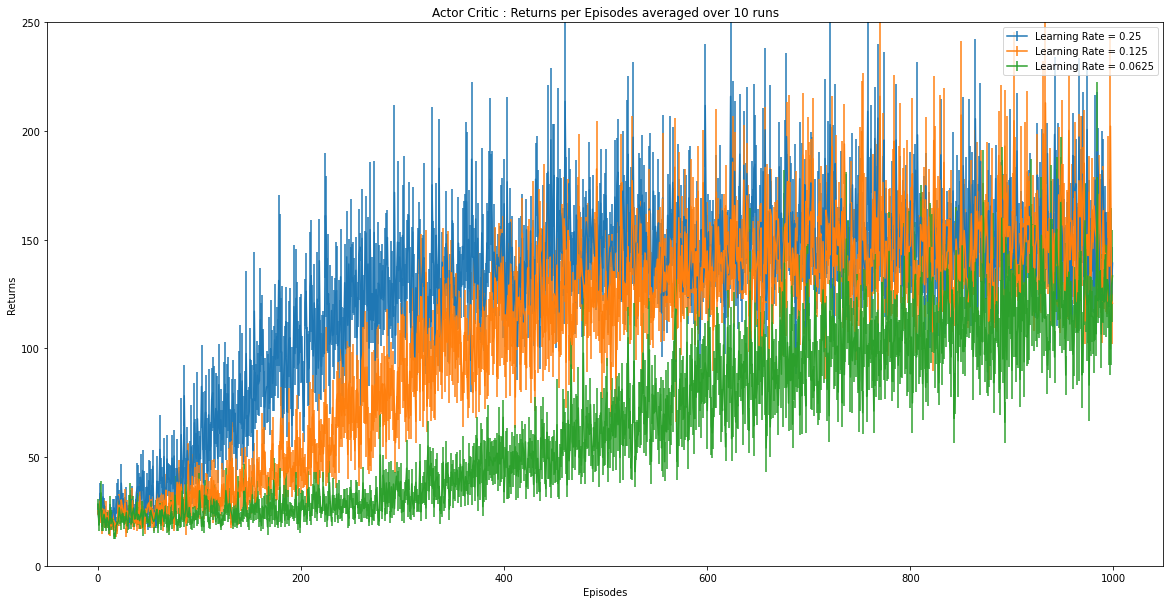

In [ ]:
xaxis = np.arange(1000)
plt.figure(figsize = (20,10))
plt.ylim(0,250)
for i in range(3):
  Lr_rewards = Rewards_np[i]
  reward_avg = np.mean(Lr_rewards,axis=0)
  reward_error = Lr_rewards.std(axis=0, ddof=1) / np.sqrt(10)
  plt.errorbar(xaxis,reward_avg,yerr = reward_error,label = "Learning Rate = {0}".format(lr[i]))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("Actor Critic : Returns per Episodes averaged over 10 runs")
plt.legend()
plt.show()

In [ ]:
#set random seed
Lrs = [1/4,1/8,1/16]
epsilons = [1/4,1/8,1/16]
GAMMA = 0.95
def Q_Learning():
  All_Reward = []
  for epsilon in epsilons:
    Epsilon_reward = []
    for alpha in Lrs:
      seed = 579
      env = gym.make('CartPole-v1')
      e1 = Encoding(env)
      alpha_reward = []
      for run in range(10):
        reward_run = []
        random.seed(seed)
        Policy = Epsilon_Greedy_Policy(e1,alpha,epsilon,env)
        for episode in range(1000):
          R_sum_episode = 0
          state = env.reset()[0]
          discrete_state = e1.get_discrete_state(state)
          while True:
            action = Policy.policy(discrete_state)
            state_next, reward, done, timeout, _= env.step(action)
            discrete_state_next = e1.get_discrete_state(state_next)
            Policy.update(discrete_state,action,GAMMA,discrete_state_next,reward)
            discrete_state = discrete_state_next
            R_sum_episode += reward
            if done or timeout:
              break
          reward_run.append(R_sum_episode)#1000
        seed += 1
        alpha_reward.append(reward_run) #10*1000
      Epsilon_reward.append(alpha_reward) # 3*10*1000
    All_Reward.append(Epsilon_reward) #3*3*10*1000
  return All_Reward

In [ ]:
Qreward = Q_Learning()

In [ ]:
np_Qreward = np.array(Qreward)

In [ ]:
np_Qreward.shape

(3, 3, 10, 1000)

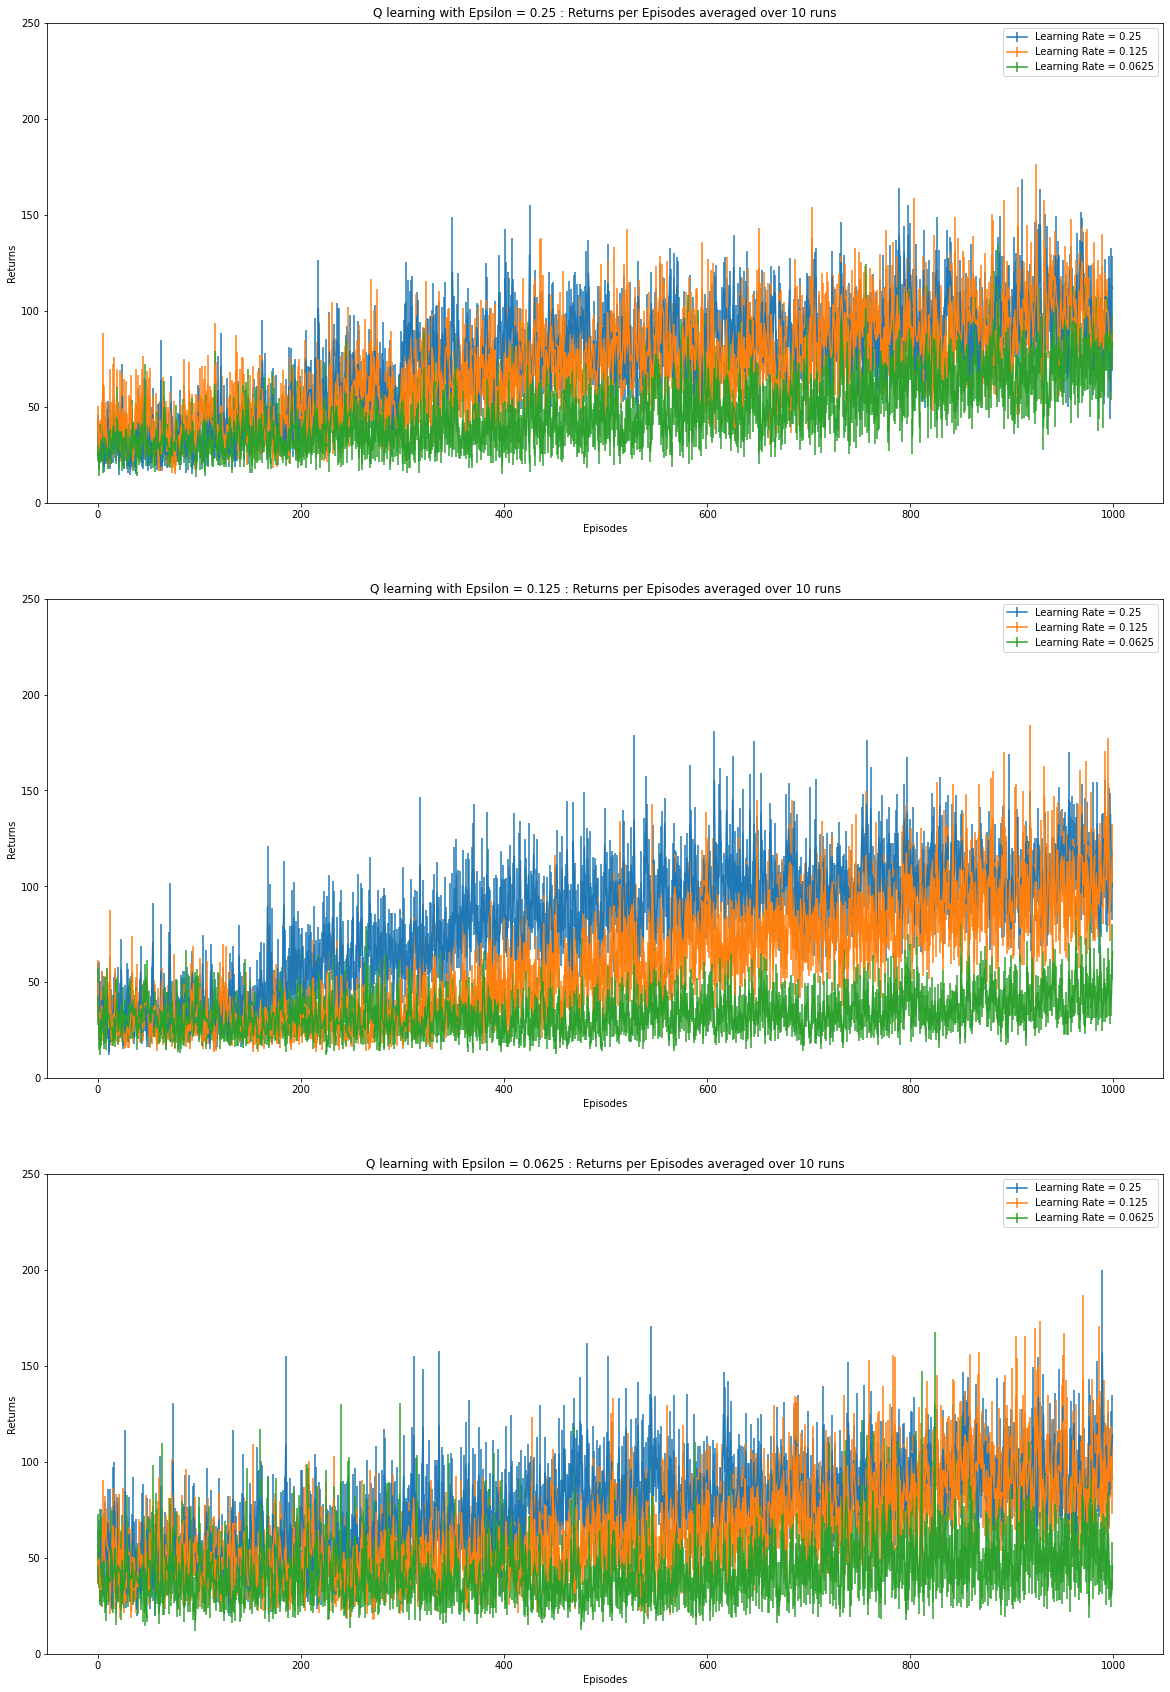

In [ ]:
xaxis = np.arange(1000)
fig, axes = plt.subplots(3, 1, figsize=(20, 30))
plt.ylim(0,300)
axes[0].set_ylim(0,250)
axes[1].set_ylim(0,250)
axes[2].set_ylim(0,250)
for i in range(3):
  Epsilon_reward = np_Qreward[i]
  for j in range(3):
    Lr_reward = Epsilon_reward[j]
    reward_avg = np.mean(Lr_reward,axis=0)
    reward_error = Lr_reward.std(axis=0, ddof=1) / np.sqrt(10)
    axes[i].errorbar(xaxis,reward_avg,yerr = reward_error,label = "Learning Rate = {0}".format(Lrs[j]))
  axes[i].set_xlabel("Episodes")
  axes[i].set_ylabel("Returns")
  axes[i].set_title("Q learning with Epsilon = {0} : Returns per Episodes averaged over 10 runs".format(epsilons[i]))
  axes[i].legend()
plt.show()
  

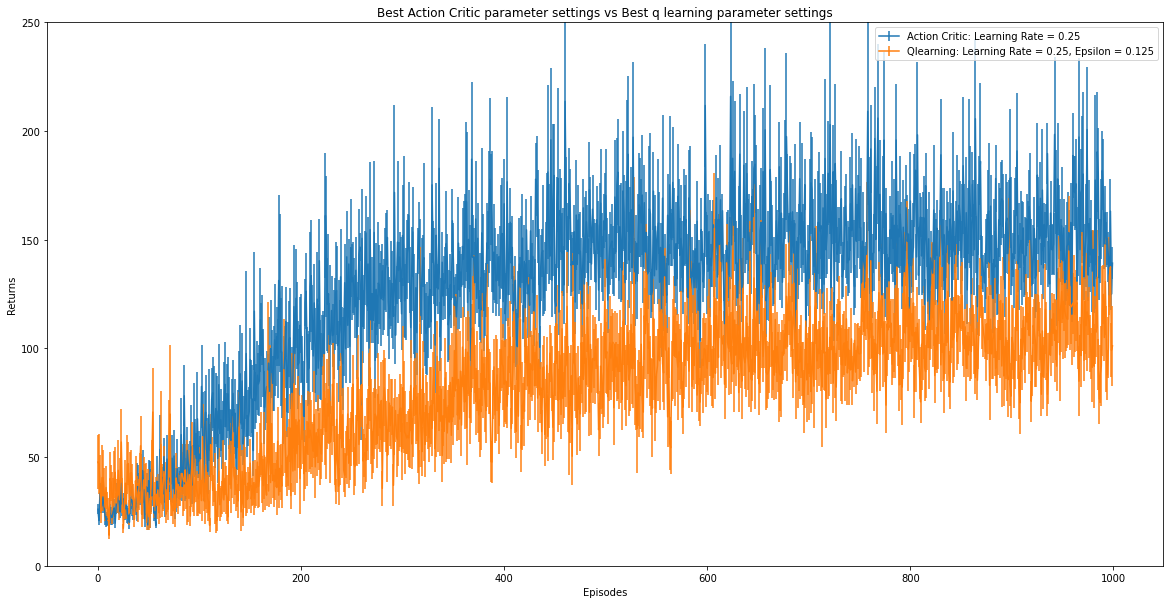

In [ ]:
#best ac
xaxis = np.arange(1000)
plt.figure(figsize = (20,10))
plt.ylim(0,250)
Lr_rewards = Rewards_np[0]
reward_avg = np.mean(Lr_rewards,axis=0)
reward_error = Lr_rewards.std(axis=0, ddof=1) / np.sqrt(10)
plt.errorbar(xaxis,reward_avg,yerr = reward_error,label = "Action Critic: Learning Rate = {0}".format(lr[0]))
# best q
Epsilon_reward = np_Qreward[1]
Lr_reward = Epsilon_reward[0]
reward_avg = np.mean(Lr_reward,axis=0)
reward_error = Lr_reward.std(axis=0, ddof=1) / np.sqrt(10)
plt.errorbar(xaxis,reward_avg,yerr = reward_error,label = "Qlearning: Learning Rate = {0}, Epsilon = {1}".format(Lrs[0],epsilons[1]))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("Best Action Critic parameter settings vs Best q learning parameter settings")
plt.legend()
plt.show()